In [1]:
# Imports
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_extraction import FeatureHasher

label_encoder = LabelEncoder()

from collections import defaultdict

warnings.simplefilter(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [2]:

def calculate_class_accuracy(y_true, y_pred):
    # Initialize dictionaries to count instances and correct predictions
    total_counts = defaultdict(int)
    correct_counts = defaultdict(int)
    
    # Populate the dictionaries with the actual counts
    for true_label, pred_label in zip(y_true, y_pred):
        total_counts[true_label] += 1
        if true_label == pred_label:
            correct_counts[true_label] += 1
            
    # Calculate accuracy for each class
    class_accuracy = {}
    for label in total_counts:
        if total_counts[label] > 0:  # Avoid division by zero
            class_accuracy[label] = correct_counts[label] / total_counts[label]
        else:
            class_accuracy[label] = 0.0
            
    return class_accuracy


In [3]:
def column_select(df, columns_to_select):
    selected_columns = []
    for column_name in columns_to_select:
        # Check if the column exists in the DataFrame
        if column_name in df.columns:
            # If the column exists, select it and add it to the list of selected columns
            selected_columns.append(column_name)
        else:
            # If the column does not exist, issue a warning
            print(f"Column '{column_name}' does not exist in the DataFrame.")

    # Select the columns from the DataFrame
    return df[selected_columns]


In [4]:
def barplot(preds):
    categories, counts = np.unique(preds, return_counts=True)
    print(counts)
    plt.bar(categories, counts)
    plt.xlabel("label")
    plt.ylabel("n entries")
    plt.title("entries per label (XGBoost)")

In [5]:
BDHS_14_child = pd.read_stata("./data/2014/BDKR72FL.DTA")
BDHS_14_household = pd.read_stata("./data/2014/BDHR72FL.DTA")
BDHS_14_individual = pd.read_stata("./data/2014/BDIR72FL.DTA")
BDHS_14_hh_member = pd.read_stata("./data/2014/BDPR72FL.DTA")
BDHS_14 = pd.concat([BDHS_14_child,BDHS_14_household, BDHS_14_individual, BDHS_14_hh_member], axis =1)


In [6]:
islam = ["v012", "v025", "hv270", "v106", "v404", "v714","v213", "v201", "v701", "v113", "v116","v130", 'v161', 'ha40']        # 2014
bins = [0, 1850, 2490, float('inf')]
labels = ['underweight', 'normal', 'obese']


islam_df = column_select(BDHS_14, islam)
islam_df['ha40'] = pd.to_numeric(islam_df['ha40'], errors='coerce')

islam_df['label'] = pd.cut(islam_df['ha40'], bins=bins, labels=labels, right=False)
islam_df = islam_df[islam_df['label'].notna()]
islam_df = islam_df.drop('ha40', axis=1)
#print(islam_df)

/tmp/ipykernel_1590/136944746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  islam_df['ha40'] = pd.to_numeric(islam_df['ha40'], errors='coerce')
/tmp/ipykernel_1590/136944746.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  islam_df['label'] = pd.cut(islam_df['ha40'], bins=bins, labels=labels, right=False)


In [7]:


y = islam_df['label']
X = islam_df.drop(['label'], axis=1)

X = X.astype(str)

hasher = FeatureHasher(n_features=20, input_type='string')
X_encoded = hasher.fit_transform(X.values)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
ros = RandomOverSampler(random_state=42, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.2, 'min_samples_split': 10, 'n_estimators': 500, 'subsample': 0.8}
Best Score: 0.5109962955791019
Accuracy: 0.4661842471472307
[1663  745 1185]
{'normal': 0.49117647058823527, 'underweight': 0.4893939393939394, 'obese': 0.3919372900335946}


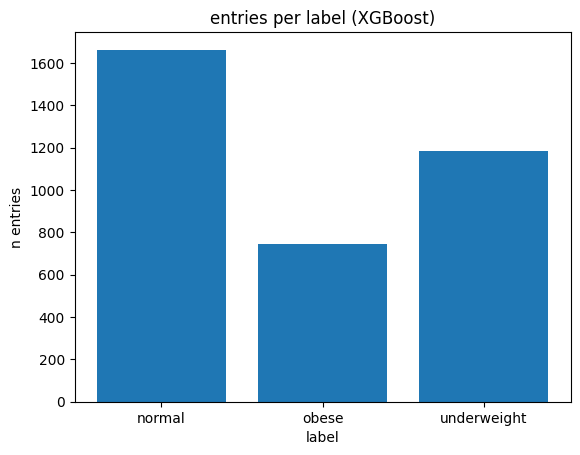

In [30]:
# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500 ],  # Number of trees in the forest
    'min_samples_split': [10, 15],   # Minimum number of samples required to split an internal node
    'subsample': [ 0.4, 0.8],
}
y_train_encoded = label_encoder.fit_transform(y_resampled)


model = GradientBoostingClassifier(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the GridSearchCV instance to the data
grid_search.fit( X_resampled, y_train_encoded)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on the testing data
y_pred_encoded = grid_search.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

barplot(y_pred)
class_accuracy = calculate_class_accuracy(y_test, y_pred)
print(class_accuracy)

In [33]:
categories, counts = np.unique(y_test, return_counts=True)
print(categories,counts)

['normal' 'obese' 'underweight'] [2040  893  660]
